In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import folium
from geopy.geocoders import Nominatim
from IPython.display import display
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

In [2]:
FOLDER_BA = './BeerAdvocate/'
beers_ba = pd.read_csv(FOLDER_BA + 'beers.csv')
breweries_ba = pd.read_csv(FOLDER_BA + 'breweries.csv')
users_ba = pd.read_csv(FOLDER_BA + 'users.csv')

FOLDER_RB = './RateBeer/'
beers_rb = pd.read_csv(FOLDER_RB + 'beers.csv')
breweries_rb = pd.read_csv(FOLDER_RB + 'breweries.csv')
users_rb = pd.read_csv(FOLDER_RB + 'users.csv')

In [3]:
ratings_ba_csv = pd.read_csv(FOLDER_BA + 'ratings_ba_clean.csv')


In [4]:
ratings_rb_csv = pd.read_csv(FOLDER_RB + 'ratings_rb_clean.csv')

In [5]:
pickle.dump(ratings_ba_csv, open('ratings_ba.pkl', 'wb'))

In [6]:
pickle.dump(ratings_rb_csv, open('ratings_rb.pkl', 'wb'))

In [7]:
ratings_ba = pickle.load(open('ratings_ba.pkl', 'rb'))
ratings_rb = pickle.load(open('ratings_rb.pkl', 'rb'))

In [8]:
user_ratings_ba = users_ba.merge(ratings_ba, how = 'right', on = 'user_id')
user_ratings_rb = users_rb.merge(ratings_rb, how = 'right', on = 'user_id')

In [9]:
print(user_ratings_ba.shape, user_ratings_rb.shape)


(8393032, 23) (7123806, 21)


In [10]:
user_ratings_ba['date'] = pd.to_datetime(user_ratings_ba['date'], unit='s')
user_ratings_rb['date'] = pd.to_datetime(user_ratings_rb['date'], unit='s')

In [11]:
user_ratings_ba['date']


0         2015-08-20 10:00:00
1         2009-02-20 11:00:00
2         2006-03-13 11:00:00
3         2004-12-01 11:00:00
4         2004-08-30 10:00:00
                  ...        
8393027   2006-02-27 11:00:00
8393028   2006-02-19 11:00:00
8393029   2004-08-10 10:00:00
8393030   2012-07-08 10:00:00
8393031   2006-02-19 11:00:00
Name: date, Length: 8393032, dtype: datetime64[ns]

In [12]:
user_ratings_ba['month'] = user_ratings_ba['date'].dt.month
user_ratings_ba['year'] = user_ratings_ba['date'].dt.year
user_ratings_rb['month'] = user_ratings_rb['date'].dt.month
user_ratings_rb['year'] = user_ratings_rb['date'].dt.year

In [13]:
user_ratings_ba['year_month'] = user_ratings_ba['date'].dt.to_period('M')
user_ratings_rb['year_month'] = user_ratings_rb['date'].dt.to_period('M')

### Compare RateBeers and BeerAdvocate: where do the ratings come from?

**Which columns have missing values?**

In [14]:
user_ratings_ba.isna().any()

nbr_ratings     False
nbr_reviews     False
user_id         False
user_name_x      True
joined           True
location         True
Unnamed: 0      False
beer_name       False
beer_id         False
brewery_name    False
brewery_id      False
style           False
abv              True
date            False
user_name_y      True
appearance       True
aroma            True
palate           True
taste            True
overall          True
rating          False
text             True
review          False
month           False
year            False
year_month      False
dtype: bool

In [15]:
user_ratings_rb.isna().any()

nbr_ratings      True
user_id         False
user_name_x      True
joined           True
location         True
Unnamed: 0      False
beer_name       False
beer_id         False
brewery_name    False
brewery_id      False
style           False
abv              True
date            False
user_name_y     False
appearance      False
aroma           False
palate          False
taste           False
overall         False
rating          False
text             True
month           False
year            False
year_month      False
dtype: bool

**Drop NaN for location -> remove ratings where location is not mentioned**

In [16]:
missing_values_location_ba = 100 * user_ratings_ba['location'].isna().sum() / user_ratings_ba.shape[0]
missing_values_location_rb = 100 * user_ratings_rb['location'].isna().sum() / user_ratings_rb.shape[0]

In [17]:
print(f"users_ratings_ba has {missing_values_location_ba:.2f}% missing values in location")
print(f"users_ratings_rb has {missing_values_location_rb:.2f}% missing values in location")

users_ratings_ba has 5.96% missing values in location
users_ratings_rb has 2.86% missing values in location


In [18]:
user_ratings_ba = user_ratings_ba.dropna(subset='location')
user_ratings_rb = user_ratings_rb.dropna(subset='location')

**New column: country, to remove states in USA**

In [19]:
def extract_country(location):
    if ',' in location:
        # If there is a comma in the location, split the string and take the first part
        return location.split(',')[0].strip()
    else:
        # If there is no comma, return the original location
        return location.strip()

In [20]:
user_ratings_ba['country'] = user_ratings_ba['location'].apply(extract_country)
user_ratings_rb['country'] = user_ratings_rb['location'].apply(extract_country)

**Plot contribution of different countries in the % of ratings in Beer Advocate and RateBeer**

In [21]:
by_country_ba = (user_ratings_ba.groupby('country')['rating'].count()*100 / user_ratings_ba.shape[0]).sort_values(ascending=False)
by_country_rb = (user_ratings_rb.groupby('country')['rating'].count()*100 / user_ratings_rb.shape[0]).sort_values(ascending =False)
top_20_countries_ba = by_country_ba.nlargest(20)
top_20_countries_rb = by_country_rb.nlargest(20)

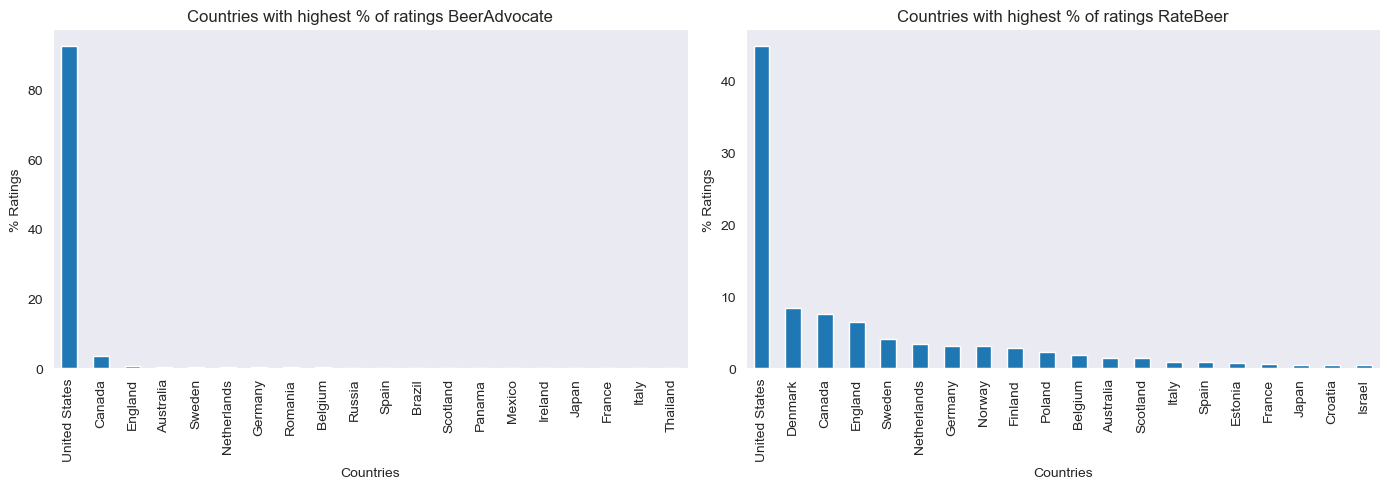

In [22]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize = (14,5))

top_20_countries_ba.plot(kind='bar', ax = axes[0])
axes[0].set_xlabel('Countries')
axes[0].set_ylabel('% Ratings')
axes[0].set_title('Countries with highest % of ratings BeerAdvocate')

top_20_countries_rb.plot(kind='bar', ax = axes[1])
axes[1].set_xlabel('Countries')
axes[1].set_ylabel('% Ratings')
axes[1].set_title('Countries with highest % of ratings RateBeer')

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

**Mapping of ratings**

In [23]:
def get_coordinates(country):
    geolocator = Nominatim(user_agent="geoapiExercices")
    try:
        location = geolocator.geocode(country, language='en')
        return (location.latitude,location.longitude)
    except:
        return (None,None)

In [24]:
def plot_map_ratings (user_ratings):
    country_counts = user_ratings['country'].value_counts().reset_index()
    country_counts.columns = ['country', 'nbr_ratings']
    country_counts['Coordinates'] = country_counts['country'].apply(get_coordinates)
    
    m = folium.Map(location=[0,0],zoom_start=2)
    
    for _, row in country_counts.iterrows():
        if row['Coordinates'][0] is not None:
            folium.Circle(
                location= row['Coordinates'],
                radius= row['nbr_ratings'],
                color= 'crimson',
                fill= True,
                fill_color= 'crimson',
                popup='{}: {} ratings'.format(row['country'], row['nbr_ratings'])
            ).add_to(m)
            
    return m

In [25]:
display(plot_map_ratings(user_ratings_ba))

In [26]:
display(plot_map_ratings(user_ratings_rb))


**What is the most rated style the whole world (in RateBeer)?**

In [27]:
beer_style_counts = user_ratings_rb.groupby('style')['style'].agg('count')

In [28]:
beer_style_counts = beer_style_counts.sort_values (ascending=False)

In [29]:
top_20_beer_style = beer_style_counts.head(20)

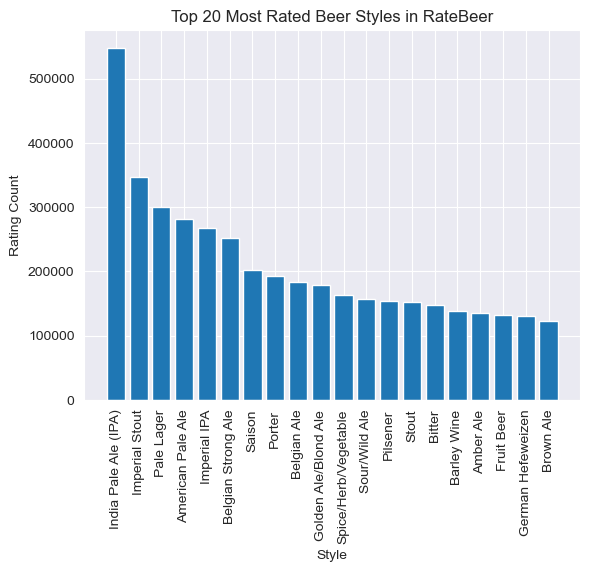

In [30]:
plt.bar(top_20_beer_style.index, top_20_beer_style.values)
plt.xlabel('Style')
plt.ylabel('Rating Count')
plt.title('Top 20 Most Rated Beer Styles in RateBeer')
plt.xticks(rotation=90)
plt.show()

**...and in BeerAdvocate?**

In [31]:
beer_style_counts_ba = user_ratings_ba.groupby('style')['style'].agg('count')
beer_style_counts_ba = beer_style_counts_ba.sort_values (ascending=False)
top_20_beer_style_ba = beer_style_counts_ba.head(20)

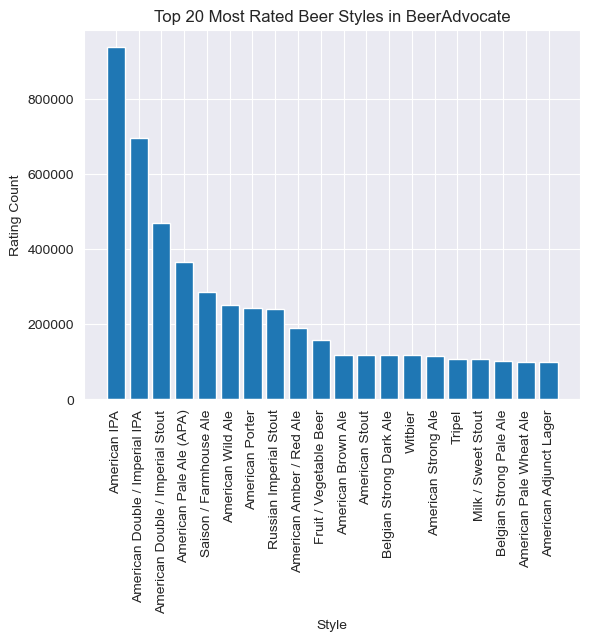

In [32]:
plt.bar(top_20_beer_style_ba.index, top_20_beer_style_ba.values)
plt.xlabel('Style')
plt.ylabel('Rating Count')
plt.title('Top 20 Most Rated Beer Styles in BeerAdvocate')
plt.xticks(rotation=90)
plt.show()

**Most reviewed in RateBeers but only in the US**

In [33]:
beer_style_counts_rb_us = user_ratings_rb[user_ratings_rb['country'] == 'United States'].groupby('style')['style'].agg('count')

In [34]:
beer_style_counts_rb_us

style
Abbey Dubbel               30815
Abbey Tripel               48680
Abt/Quadrupel              31862
Altbier                    14951
Amber Ale                  72614
                           ...  
Traditional Ale            11923
Weizen Bock                13770
Wheat Ale                  44995
Witbier                    46664
Zwickel/Keller/Landbier     7561
Name: style, Length: 90, dtype: int64

In [35]:
beer_style_counts_rb_us = beer_style_counts_rb_us.sort_values (ascending=False)

In [36]:
top_20_beer_style_rb_us = beer_style_counts_rb_us.head(20)

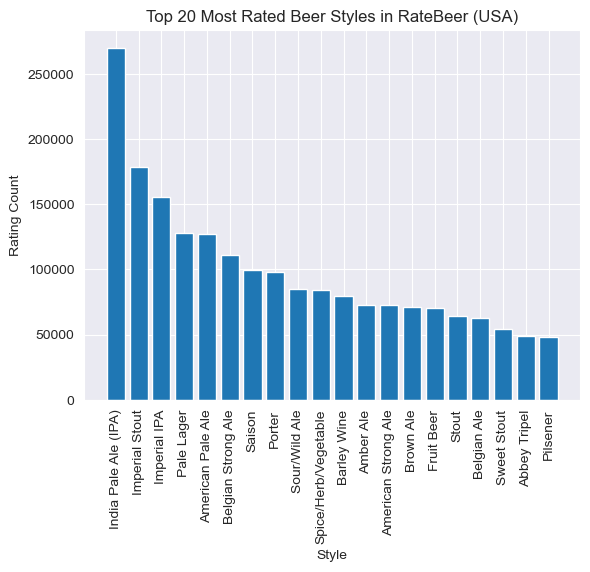

In [37]:
plt.bar(top_20_beer_style_rb_us.index, top_20_beer_style_rb_us.values)
plt.xlabel('Style')
plt.ylabel('Rating Count')
plt.title('Top 20 Most Rated Beer Styles in RateBeer (USA)')
plt.xticks(rotation=90)
plt.show()

**Distribution of ratings per month for all beers**

In [38]:
all_beer_all_world_rb = user_ratings_rb[
    (user_ratings_rb['year'] >= 2010) &
    (user_ratings_rb['year'] <= 2016)
]

In [39]:
all_beer_ratings_all_world_rb = all_beer_all_world_rb.groupby('year_month')["rating"].count()

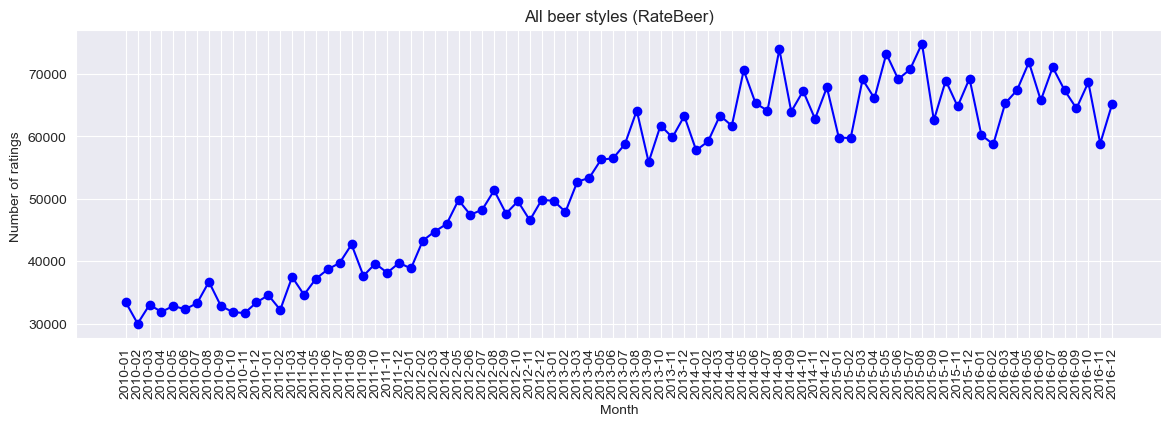

In [40]:
plt.figure(figsize = (14,4))
plt.plot(all_beer_ratings_all_world_rb.index.astype(str), all_beer_ratings_all_world_rb.values, marker = 'o', color = 'blue')
plt.xlabel('Month')
plt.ylabel('Number of ratings ')
plt.title('All beer styles (RateBeer)')
plt.xticks(rotation = 90)
#plt.ylim(0,75000)
plt.show()

**Distribution of IPA reviews normalized according to total number of reviews**

In [41]:
ipa_all_world_rb = all_beer_all_world_rb[(all_beer_all_world_rb['style'] == 'India Pale Ale (IPA)')]

In [83]:
ipa_ratings_per_month_all_world_rb = ipa_all_world_rb.groupby('year_month')["rating"].count()

In [43]:
ipa_ratings_perc_rb = ipa_ratings_per_month_all_world_rb / all_beer_ratings_all_world_rb

In [84]:
def plot_STL(ratings_per_month):
    ratings_per_month.index = ratings_per_month.index.to_timestamp()

    stl = STL(ratings_per_month, seasonal=13, period=12)
    result = stl.fit()
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    plt.figure(figsize=(10, 6))
    plt.subplot(411)
    plt.plot(ipa_ratings_per_month_all_world_rb, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()

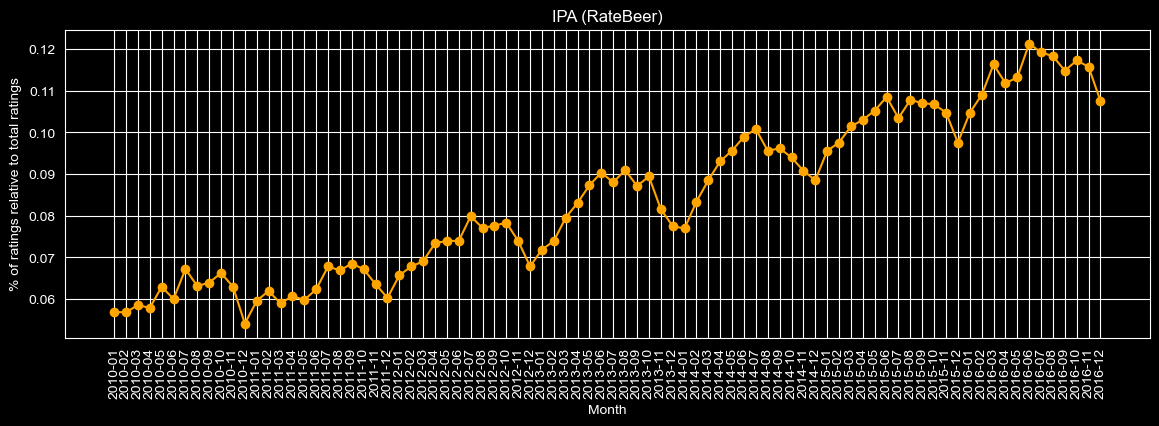

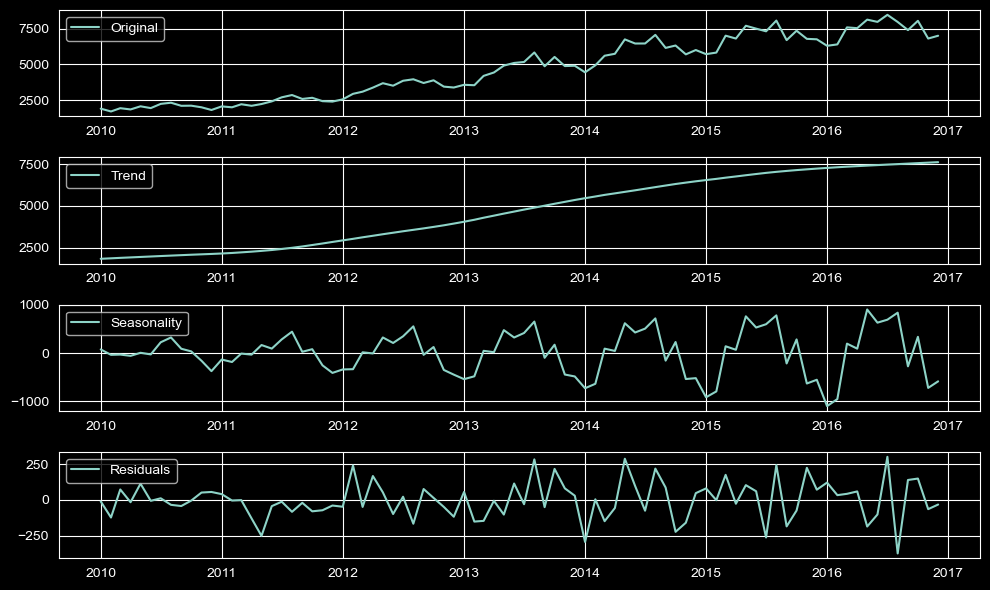

In [85]:
plt.figure(figsize = (14,4))
plt.plot(ipa_ratings_perc_rb.index.astype(str), ipa_ratings_perc_rb.values, marker = 'o', color = 'orange')
plt.xlabel('Month')
plt.ylabel('% of ratings relative to total ratings')
plt.title('IPA (RateBeer)')
plt.xticks(rotation = 90)
plt.show()
plot_STL(ipa_ratings_per_month_all_world_rb)

**Same thing for Pilsener**

In [45]:
pilsener = all_beer_all_world_rb[(all_beer_all_world_rb['style'] == 'Pilsener')]

In [87]:
pilsener_per_month_all_world_rb = pilsener.groupby('year_month')["rating"].count()

In [47]:
pilsener_ratings_perc_rb = pilsener_per_month_all_world_rb / all_beer_ratings_all_world_rb

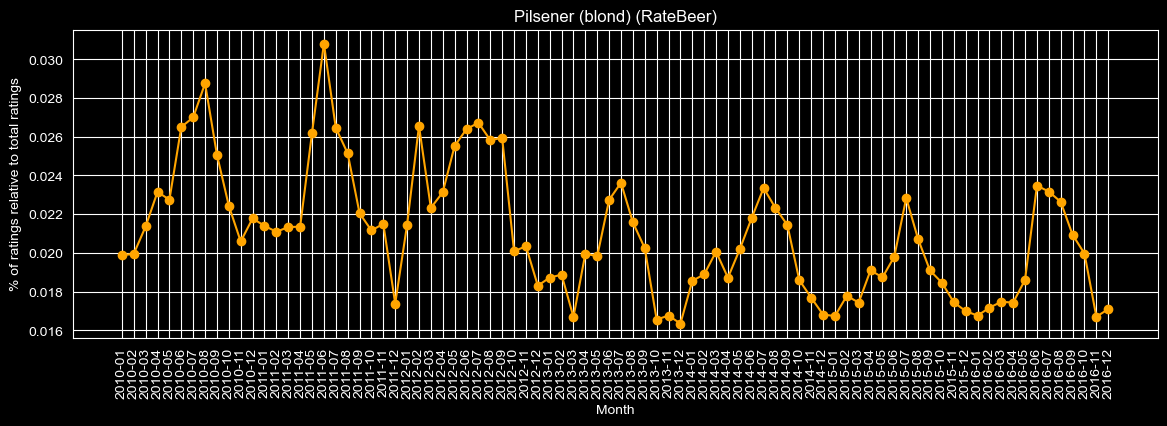

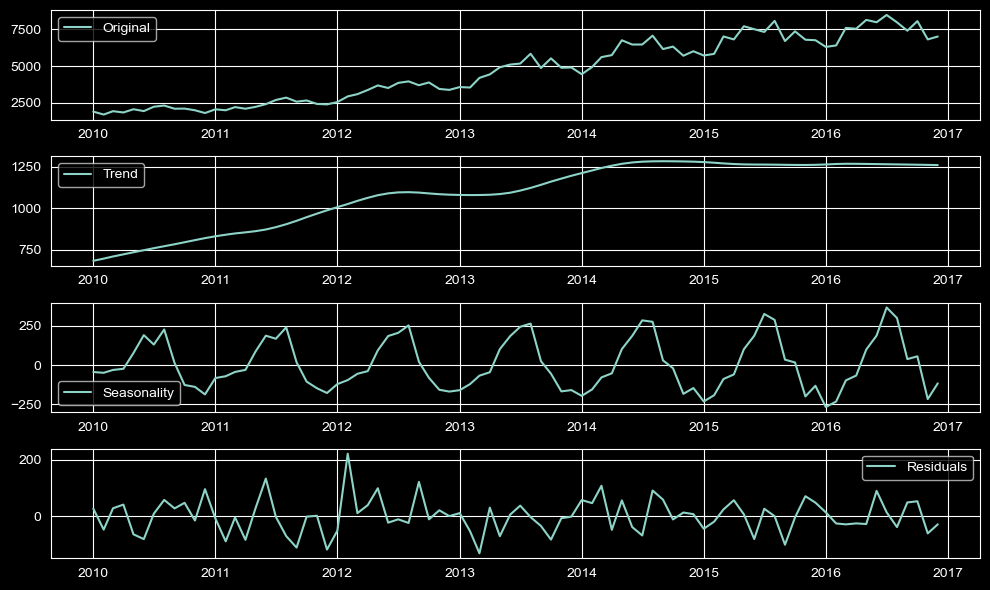

In [88]:
plt.figure(figsize = (14,4))
#plt.plot(pilsener_ratings_per_month.index.astype(str), pilsener_ratings_per_month.values, marker = 'o')
plt.plot(pilsener_ratings_perc_rb.index.astype(str), pilsener_ratings_perc_rb.values, marker = 'o', color = 'orange')
plt.xlabel('Month')
plt.ylabel('% of ratings relative to total ratings')
plt.title('Pilsener (blond) (RateBeer)')
plt.xticks(rotation = 90)
plt.show()
plot_STL(pilsener_per_month_all_world_rb)


**Belgian Strong Ale**

In [49]:
belg_strong_ale_rb = all_beer_all_world_rb[(all_beer_all_world_rb['style'] == 'Belgian Strong Ale')]

In [89]:
belg_strong_ale_per_month_all_world_rb = belg_strong_ale_rb.groupby('year_month')["rating"].count()

In [51]:
belg_strong_ale_ratings_perc_rb = belg_strong_ale_per_month_all_world_rb / all_beer_ratings_all_world_rb

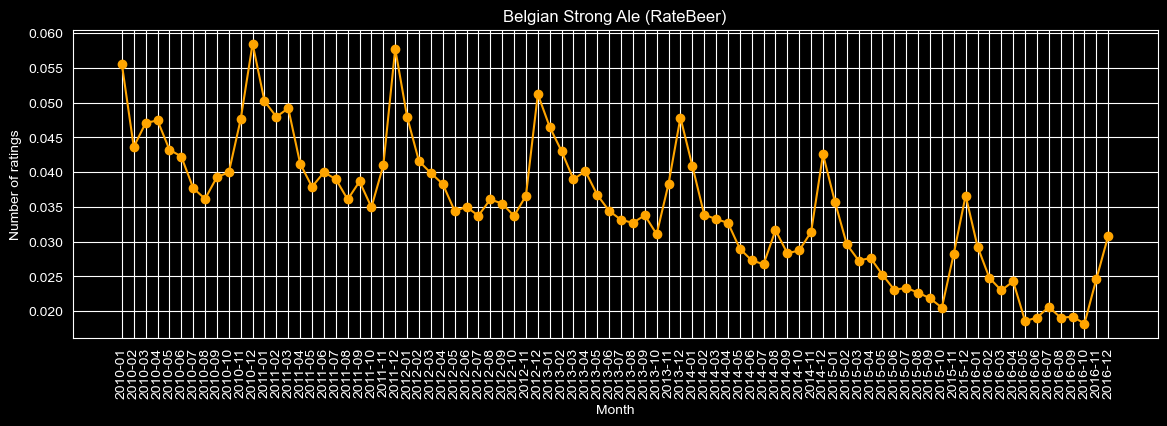

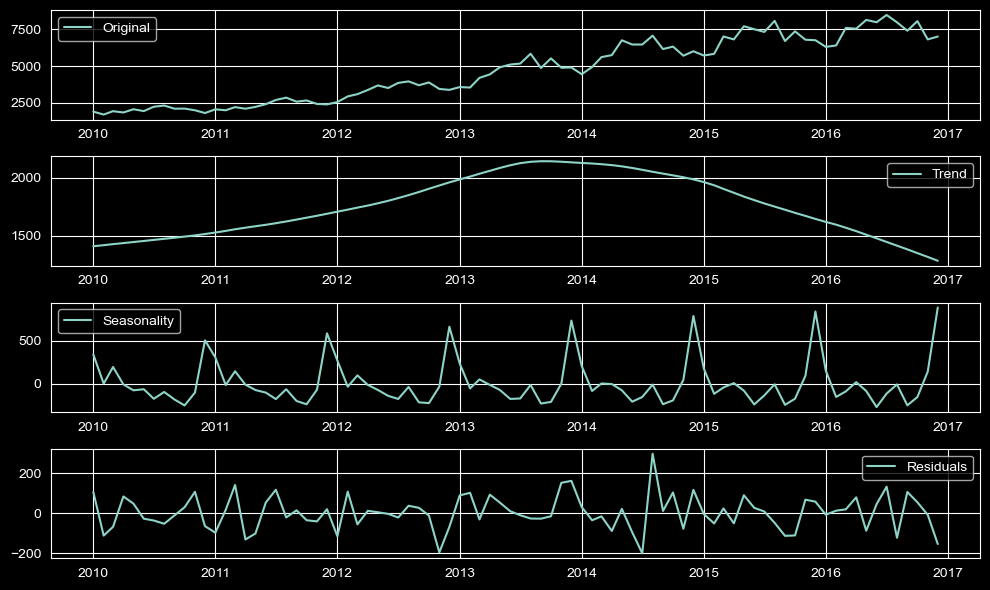

In [90]:
plt.figure(figsize = (14,4))
#plt.plot(belg_strong_ale_ratings_per_month.index.astype(str), belg_strong_ale_ratings_per_month.values, marker = 'o')
plt.plot(belg_strong_ale_ratings_perc_rb.index.astype(str), belg_strong_ale_ratings_perc_rb.values, marker = 'o', color = 'orange')
plt.xlabel('Month')
plt.ylabel('Number of ratings')
plt.title('Belgian Strong Ale (RateBeer)')
plt.xticks(rotation = 90)
plt.show()
plot_STL(belg_strong_ale_per_month_all_world_rb)

**Distribution of alcohol degree among beers compared to ratings -> do people drink a lot of strong beers? (RateBeer only)**

In [53]:
user_ratings_less_15_rb = user_ratings_rb[user_ratings_rb['abv'] <= 15]

In [54]:
beers_less_15_rb = beers_rb[beers_rb['abv'] <= 15]

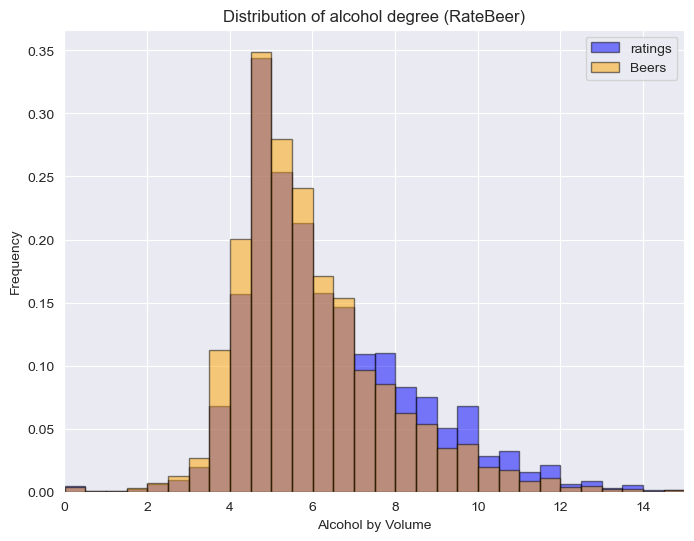

In [55]:
plt.figure(figsize = (8,6))
plt.hist(user_ratings_less_15_rb['abv'], bins = 30, color = 'blue', label = 'ratings', density = True, alpha = 0.5, edgecolor = 'black')
plt.hist(beers_less_15_rb['abv'], bins = 30, color = 'orange', label = 'Beers', density = True, alpha = 0.5, edgecolor = 'black')
plt.xlabel('Alcohol by Volume')
plt.ylabel('Frequency')
plt.title('Distribution of alcohol degree (RateBeer)')
plt.xlim(0,15)
plt.legend()
plt.show()

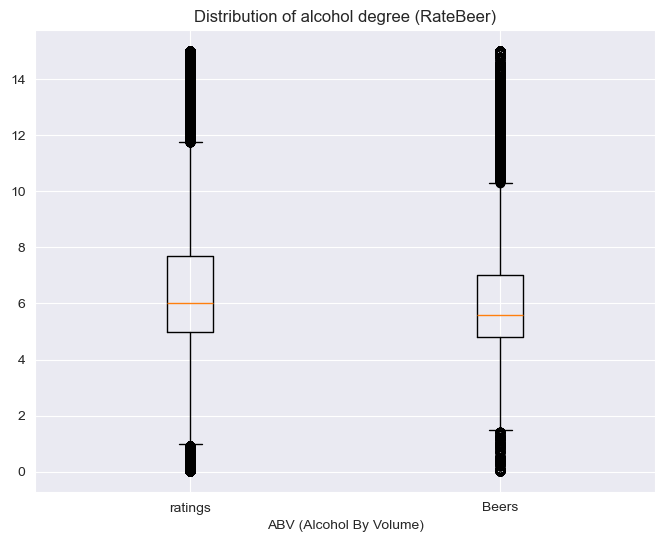

In [56]:
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.boxplot([user_ratings_less_15_rb['abv'], beers_less_15_rb['abv']], labels=['ratings', 'Beers'])
plt.title('Distribution of alcohol degree (RateBeer)')
plt.xlabel('ABV (Alcohol By Volume)')
plt.show()

In [57]:
pils = beers_less_15_rb[beers_less_15_rb['style'] == 'Pilsener']
bsa = beers_less_15_rb[beers_less_15_rb['style'] == 'Belgian Strong Ale']

In [58]:
pils

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
55,526621,Boundary Generic,22818,Boundary,Pilsener,1,NaN,NaN,2.89,5.0,2.800000,NaN,0,NaN
214,360989,Mourne Mountains Mourne Mist,23165,Mourne Mountains Brewery,Pilsener,1,NaN,NaN,3.00,4.5,3.300000,-0.412028,1,3.3
255,368965,Walled City Kicks,24866,Walled City,Pilsener,1,NaN,NaN,3.00,4.1,3.300000,NaN,0,NaN
303,457548,AdstraGold Oaky Pilsner Premium,15008,AdstraGold Microbrewery & Bistro Bar,Pilsener,2,NaN,NaN,2.81,3.5,2.600000,NaN,0,NaN
304,224981,AdstraGold Pilsner Premium,15008,AdstraGold Microbrewery & Bistro Bar,Pilsener,5,NaN,NaN,2.78,3.0,2.220000,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442051,73708,Korça Bjonde,8244,Birra Korça,Pilsener,95,4.0,6.0,2.11,4.5,2.081053,NaN,0,NaN
442064,349608,Deutch Beer,23853,Hyseni sh.p.k.,Pilsener,1,NaN,NaN,2.72,4.5,2.000000,NaN,0,NaN
442065,439458,Birra King Pils,28180,Shoqeria Picana,Pilsener,2,NaN,NaN,3.02,4.6,3.200000,NaN,0,NaN
442075,287791,Stela Pils 4%,1107,Stefani & Co,Pilsener,17,3.0,2.0,1.92,4.0,1.705882,NaN,0,NaN


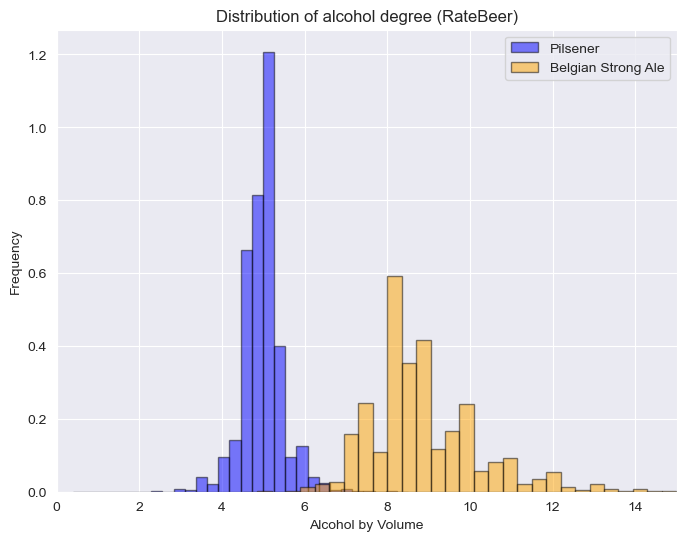

In [59]:
plt.figure(figsize = (8,6))
plt.hist(pils['abv'], bins = 30, color = 'blue', label = 'Pilsener', density = True, alpha = 0.5, edgecolor = 'black')
plt.hist(bsa['abv'], bins = 30, color = 'orange', label = 'Belgian Strong Ale', density = True, alpha = 0.5, edgecolor = 'black')
plt.xlabel('Alcohol by Volume')
plt.ylabel('Frequency')
plt.title('Distribution of alcohol degree (RateBeer)')
plt.xlim(0,15)
plt.legend()
plt.show()

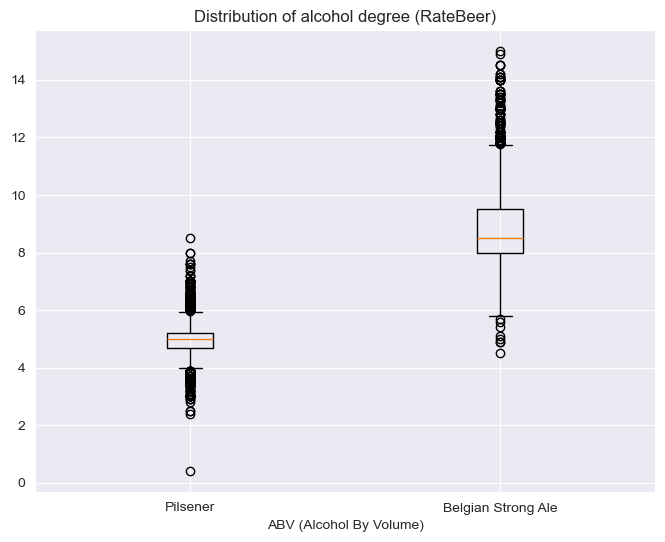

In [60]:
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.boxplot([pils['abv'], bsa['abv']], labels=['Pilsener', 'Belgian Strong Ale'])
plt.title('Distribution of alcohol degree (RateBeer)')
plt.xlabel('ABV (Alcohol By Volume)')
plt.show()

Index(['American IPA', 'American Double / Imperial IPA',
       'American Double / Imperial Stout', 'American Pale Ale (APA)',
       'Saison / Farmhouse Ale'],
      dtype='object', name='style')


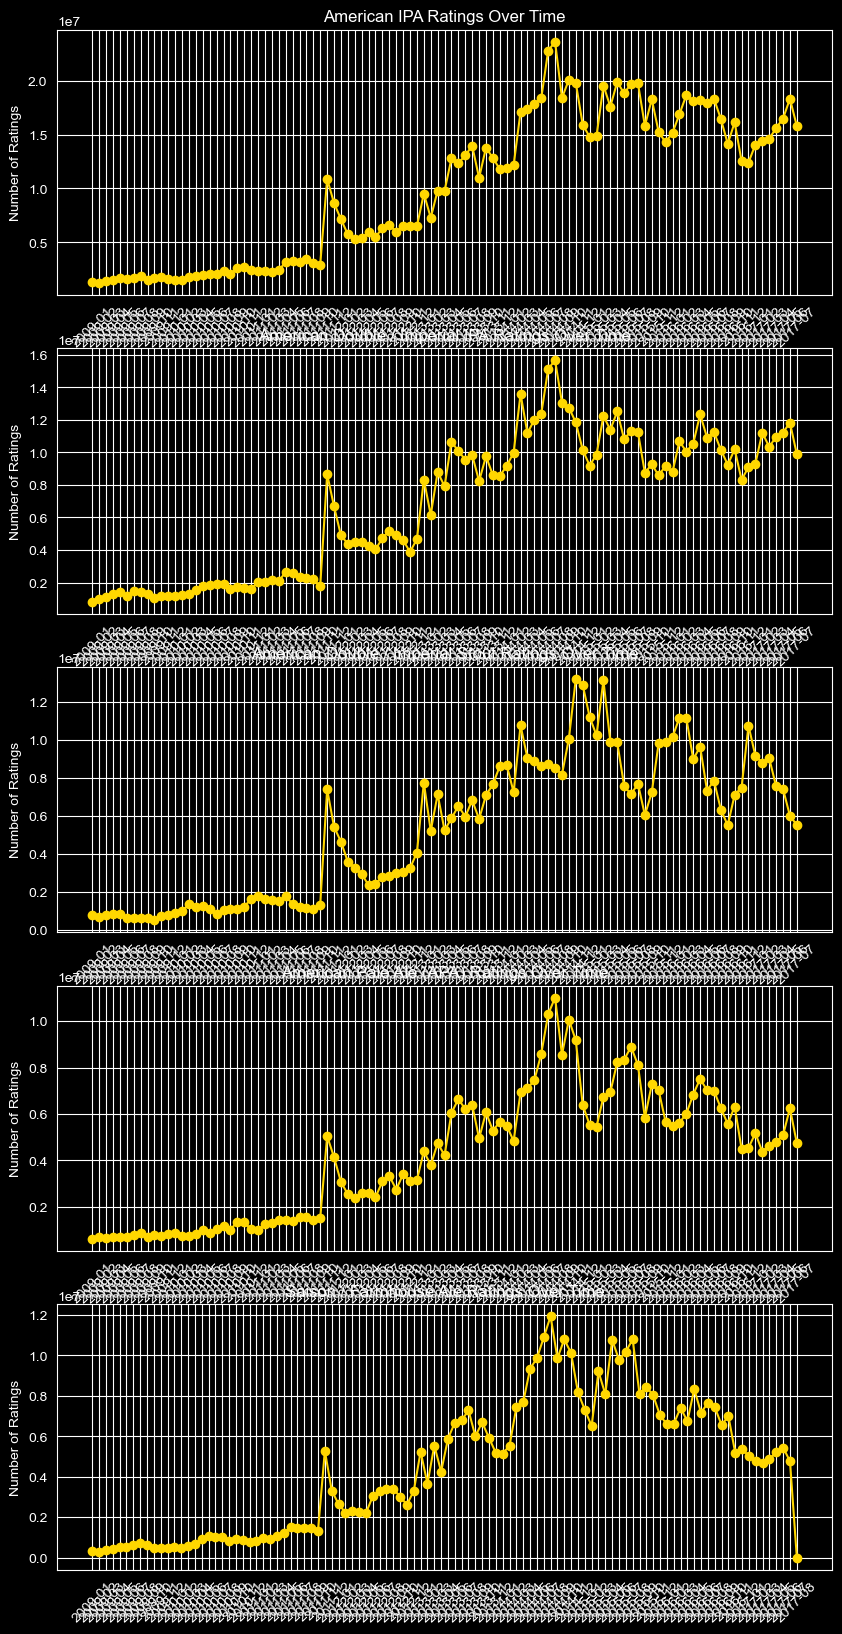

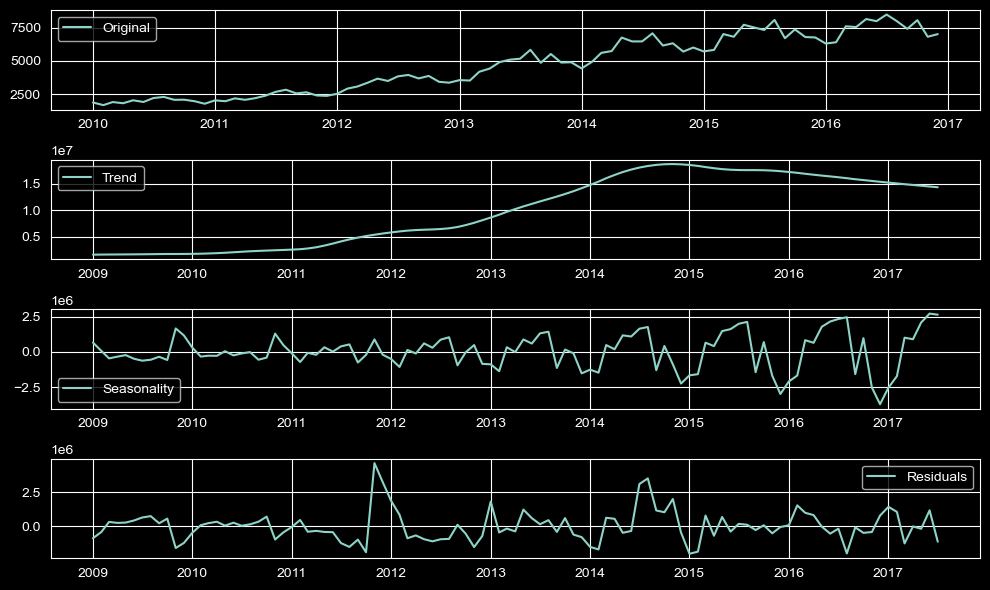

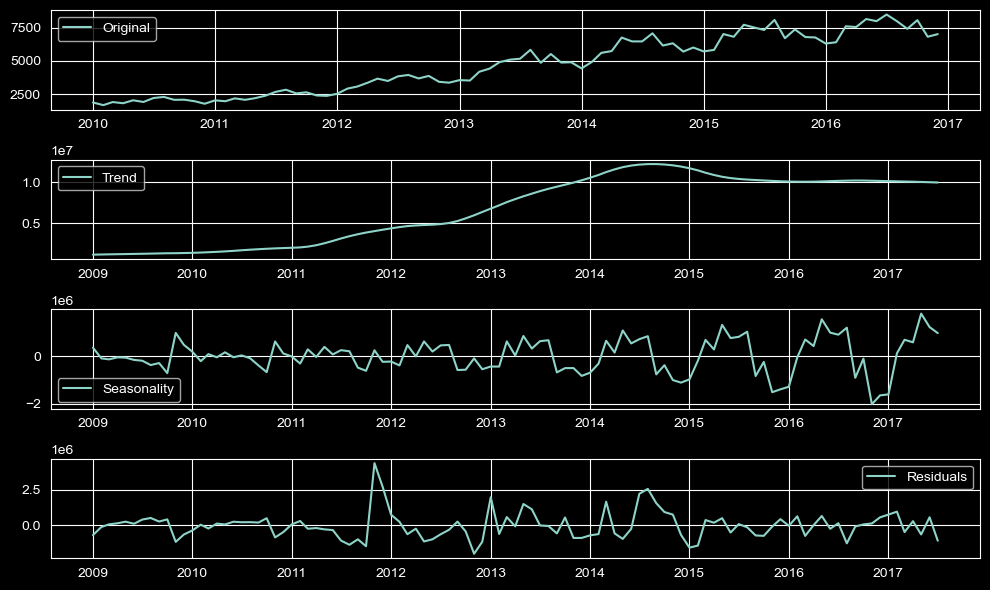

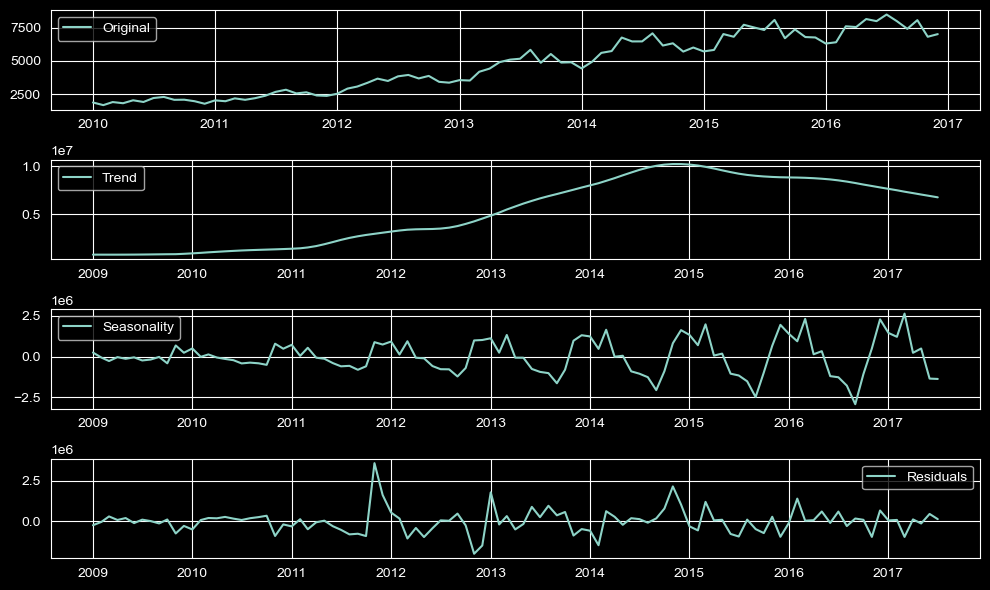

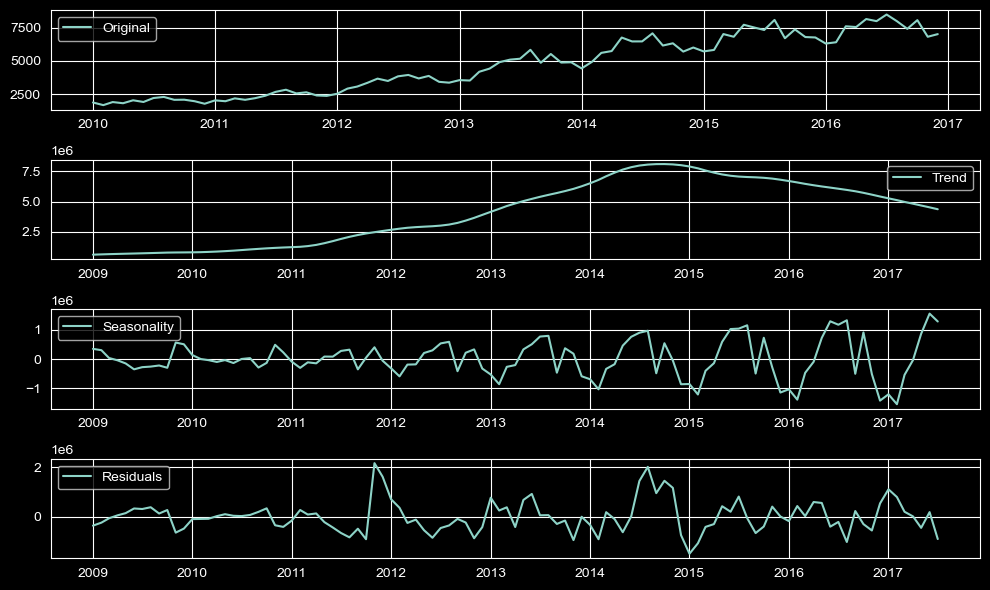

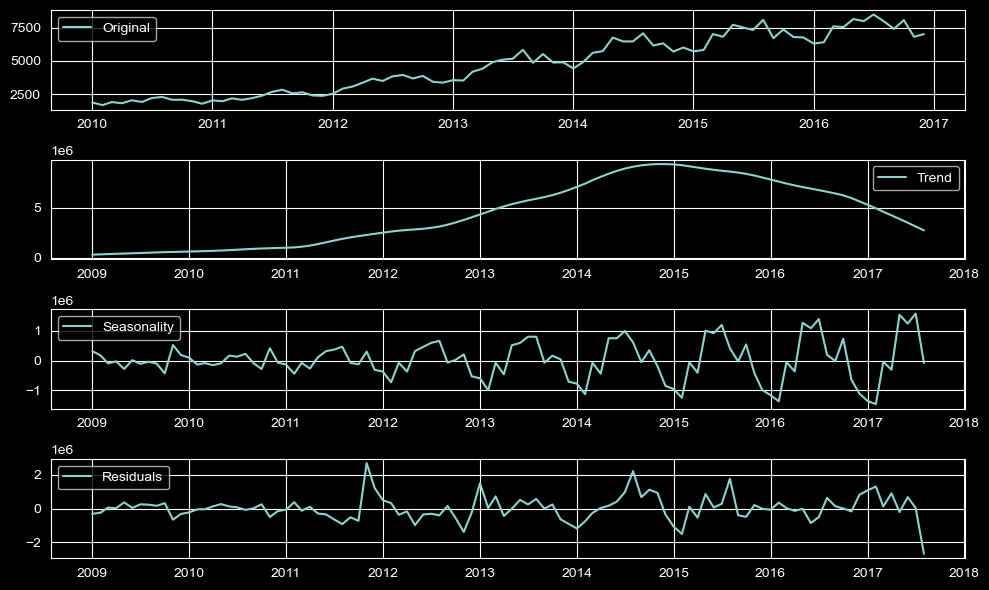

In [91]:
top_5_beers = top_20_beer_style_ba.index[:5]
print(top_5_beers)
filtered_data = user_ratings_ba[user_ratings_ba['style'].isin(top_5_beers)]
filtered_data = filtered_data[filtered_data['date'].dt.year >= 2009]


# Regrouper les données par mois et compter le nombre de notations par mois
monthly_counts = filtered_data.groupby('month').size()

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20), dpi=100)

# Customizing the aesthetics as per the provided example
plt.style.use('dark_background')

# Looping over each style and plotting it on its own subplot
for i, style in enumerate(top_5_beers):
    # Group data by 'year_month' and sum the 'nbr_ratings' for each group
    time_data = filtered_data[filtered_data['style'] == style].groupby('year_month')['nbr_ratings'].sum()
    # Plotting the data
    ax = axes[i]
    ax.plot(time_data.index.astype(str), time_data.values, color='gold', marker='o')
    
    # Setting the title for each subplot
    ax.set_title(f'{style} Ratings Over Time')

    # Formatting the x-axis to show every other month for clarity
    ax.tick_params(axis='x', rotation=45)

    # Set y-label
    ax.set_ylabel('Number of Ratings')
    plot_STL(time_data)
# Adjusting layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()